In [4]:
import numpy as np
import pandas as pd
from scipy.linalg import eigh, expm
import seaborn as sns
from qiskit import QuantumCircuit, QuantumRegister, transpile
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import PauliEvolutionGate, UnitaryGate
from qiskit.synthesis.evolution import LieTrotter
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram

In [5]:
def get_itimevol_circuit(M, H, t, psi_0, reps = 5):
    N = 3
    n_anc = 2 * M
    

    anc_idxs = list(range(n_anc))
    sys_idxs = list(range(n_anc, n_anc + N))
    alpha    = 2 * np.arctan(np.sqrt(0.5))
    beta     = 0.5 * np.pi
    gamma    = -1.5 * np.pi
    anc      = QuantumRegister(n_anc, name="a")
    syst     = QuantumRegister(N, name="q")
    qc       = QuantumCircuit(anc, syst)

    qc.initialize(psi_0, sys_idxs)

    for i in range(2 * M - 1, 0, -2): 
        # setup gates for ancillary qubits
        qc.ry(alpha, i - 1)
        qc.ry(beta, i)
        qc.cx(i - 1, i, ctrl_state = 0)
        qc.crz(gamma, control_qubit = i - 1, target_qubit = i)

        U_1    = expm(1j * H * t / M)
        U_1_op = UnitaryGate(U_1, label="U(-t/M)").control(1)
        qc.append(U_1_op, [i - 1] + sys_idxs) # control on qubit i - 1 and act on the system qubits

        U_2    = expm(-2j * H * t / M)
        U_2_op = UnitaryGate(U_2, label="U(2t/M)").control(2)
        qc.append(U_2_op, [i - 1, i] + sys_idxs) # control on qubits i - 1 and i and act on the system qubits

    # setup measurement qubits
    qc.h(anc_idxs)

    return qc

In [6]:
# consider 3 qubits
N   = 3
N_q = 2 ** N
t   = 1

A = np.random.rand(N_q, N_q) + 1j * np.random.rand(N_q, N_q) - 1
H = A + A.conj().T

evs, w = eigh(H)
w      = w.T
gs     = w[0] / np.linalg.norm(w[0]) # we need to normalize it because later we calculate eps

M_max    = 4
M_values = np.arange(1, M_max + 1)
n_points = 5
a_values = np.linspace(0, 1, n_points)

data = []

for M in M_values:
    for a_0 in a_values:
        n_anc = 2 * M
        psi_0 = a_0 * gs + np.sqrt(1 - a_0 ** 2) * w[1]
        psi_0 /= np.linalg.norm(psi_0)

        qc = get_itimevol_circuit(M, H, t, psi_0)
        qc.save_statevector()

        aer_sim = Aer.get_backend("aer_simulator_statevector_gpu")
        qc_tp   = transpile(qc, backend=aer_sim)
        result  = aer_sim.run(qc_tp).result()

        final_state_dict     = result.get_statevector(qc_tp).to_dict()
        final_state_sys_dict = {}

        for k, v in final_state_dict.items():
            if k[-n_anc:] == '0' * n_anc:
                k_new = k[:N]
                final_state_sys_dict[k_new] = v

        final_state_sys_list = sorted(final_state_sys_dict.items())
        final_state          = np.array([t[1] for t in final_state_sys_list])
        final_state          /= np.linalg.norm(final_state)

        eps = 1 - np.abs(np.dot(gs, final_state)) ** 2
        data.append((M, a_0, eps))

<Axes: xlabel='a_0', ylabel='eps'>

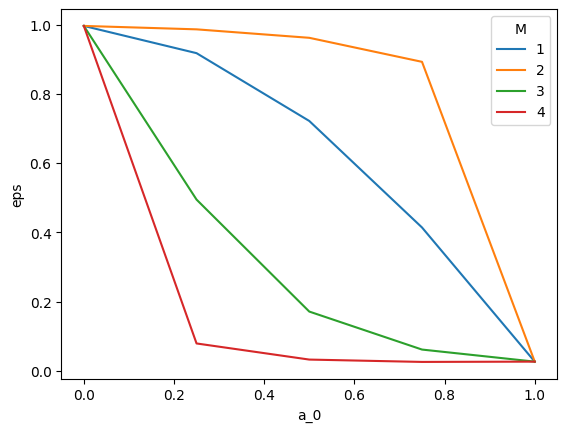

In [8]:
df = pd.DataFrame(data, columns=["M", "a_0", "eps"])
sns.lineplot(df, x = "a_0", y = "eps", hue = "M", palette="tab10")